In [18]:
import pandas as pd
import gymnasium as gym
import os
from ale_py import ALEInterface, roms
import time
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense
from keras.optimizers import Adam
import random
from collections import deque
from keras import Input
import pickle

In [4]:
env = gym.make("ALE/Casino-v5", render_mode="rgb_array", mode=2)
initial_state = env.reset()

In [5]:
screenshot=env.render()

In [12]:
def gary(image):
    gar=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gar, (84, 84), interpolation=cv2.INTER_AREA)
    return resized 

In [13]:
pros=gary(screenshot)

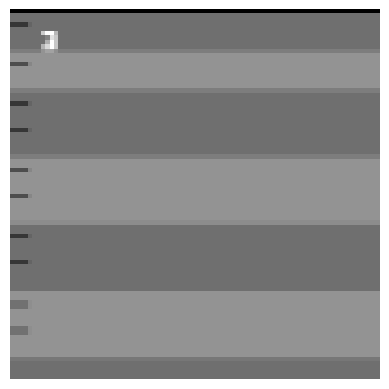

In [14]:
plt.imshow(pros,cmap='gray')
plt.axis("off")
plt.show()

In [15]:
def modl(input_shape, num_actions):
    model= Sequential([
        Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=input_shape),
        Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
        Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_actions, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
    return model

In [16]:
class DQNAgent:
    def __init__(self, action_size):
        self.memory = deque(maxlen=100000)
        self.action_size = action_size
        self.model = modl((84, 84, 1), action_size)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
    def act(self, state):
        if np.random.rand()<=self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis, :, :, np.newaxis], verbose=0)
        return np.argmax(q_values[0])
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def replay(self, batch_size=32):
        minibatch =random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target =reward
            if not done:
                next_q=np.max(self.model.predict(next_state[np.newaxis, :, :, np.newaxis], verbose=0)[0])
                target=reward+self.gamma*next_q
            q_values = self.model.predict(state[np.newaxis, :, :, np.newaxis], verbose=0)
            q_values[0][action] = target
            self.model.fit(state[np.newaxis, :, :, np.newaxis], q_values, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
env = gym.make("ALE/Casino-v5", render_mode="rgb_array", mode=2)
agent=DQNAgent(env.action_space.n)
bf=[]
br=0
be=0
episodes = 4000
for e in range(episodes):
    obs, _ = env.reset()
    env.step(env.action_space.sample())
    frame = screenshot
    state = pros
    total_reward = 0
    done=False
    fram=[]
    while not done:
        action = agent.act(state)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        fram.append(env.render())
        next_state = pros
        fram.append(screenshot)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print(f"Episode {e+1}: {total_reward}")
            if total_reward>br:
                br=total_reward
                bf=fram
            break
    if len(agent.memory) > 1000:
        agent.replay(32)
env.close()

Episode 1: 1400.0
Episode 2: 2400.0


In [ ]:
agent.model.save("model.h5")

In [ ]:
def play():
    env = gym.make("ALE/Casino-v5", render_mode="human", mode=2)
    state, _ = env.reset()
    state = gary(state)
    state = np.expand_dims(state, axis=-1)  # Add channel dimension
    state = np.expand_dims(state, axis=0)   # Add batch dimension
    
    total_reward = 0
    while True:
        # Get Q-values and choose best action
        q_values = model.predict(state, verbose=0)
        action = np.argmax(q_values[0])
        
        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Prepare next state
        next_state = gary(next_state)
        next_state = np.expand_dims(next_state, axis=-1)
        next_state = np.expand_dims(next_state, axis=0)
        
        state = next_state
        total_reward += reward
        
        if done:
            print(f"Game Over! Total reward: {total_reward}")
            break
            
    env.close()

# Run the game
if __name__ == "__main__":
    play()